### Imports

In [1]:
# Imports

import sys
'''
!{sys.executable} -m pip install --user -q cirq
!{sys.executable} -m pip install --user -q google-api-python-client==1.8.0
'''
import cirq
import math
import random
import numpy as np
import sympy
!{sys.executable} --version
print("\nCirq version " + cirq.__version__)

Python 3.7.7

Cirq version 0.7.0


# Quantum Computing Simulation using Google's cirq library for Python
### Dmitri Friedenberg


Quantum programming languages are a major developing topic in the field of quantum computing. As the availability of different quantum computing systems increases, the need rises for a clear syntax with which to program a series of operations on an arbitrary quantum computer. 

# Review of literature and high-level quantum programming proposals

Discussion about quantum pseudoprogramming began immediately after Shor's algorithm and Grover's algorithm each took the spotlight in 1994 and 1996 respectively. In "Conventions for quantum pseudocode" \[1\] in 1996, E. Knill's often cited paper began the initiative to develop a common method for programming quantum computers. Although a physical implementation was nowhere in sight, the need for adopting expressions for constructing a quantum system was immediately clear. A number of quantum programming language proposals followed in the decade after Knill's paper, well documented by Peter Selinger's "A brief survey of quantum programming languages" \[2\].

### Imperative languages

Within a few years of Knill's paper, several proposals for *imperative* quantum programming languages emerged. The first proposed imperative language was **Quantum Computation Language (QCL)**, introduced in 1998 in B. Ömer's Master's thesis, "A Procedural Formalism for Quantum Computing" \[3\]. His thesis presented a fully developed imperative language, with examples such as the QCL implementation of Coppersmith's algorithm of a fast quantum discrete Fourier Transform (Table 2.1):

```java
    operator dft(qureg q) { // main operator
        const n=#q; // set n to length of input
        int i; int j; // declare loop counters
        for i=0 to n-1 {
            for j=0 to i-1 { // apply conditional phase gates
                CPhase(2*pi/2^(i-j+1),q[n-i-1] & q[n-j-1]);
            }
            Mix(q[n-i-1]); // qubit rotation
        }
    flip(q); // swap bit order of the output
    }
```

Generally, initial proposals for quantum programming languages were imperative, likely due to the intuition that the languages are designed to manipulate physical objects (qubits and gates), more easily expressed in an object-oriented language. The imperative languages that followed included **Q Language** (an extension of C++, from "Toward an architecture for quantum programming", S. Bettelli 2002), which tracked quantum memory using a class "Qreg" to create registers; and **quantum Guarded-Command Language (qGCL)**, modeled after Edsger Dijkstra's "Guarded Command Language", defined by P. Zuliani in his thesis, "Quantum Programming" (2001).

### Functional languages

As functional programming has risen back into the zeitgeist of the last decade or two among the software engineering community, quantum computation has seen its share of attempts at functional languages. Selinger defined the **Quantum Programming Language (QPL)** in another paper from 2004, "Towards a quantum programming language" \[4\]. His paper describes QPL as, "*functional*, in the sense that each (atomic or composite) statement operates by transforming a specific set of inputs to outputs." The language implements natural solutions for issues like the no-cloning property, where the syntax of the language prevents an implied duplication of a quantum state. Selinger's paper also defines **Quantum flow charts (QFC)**, an excellent tool for illustrating a quantum functional program:

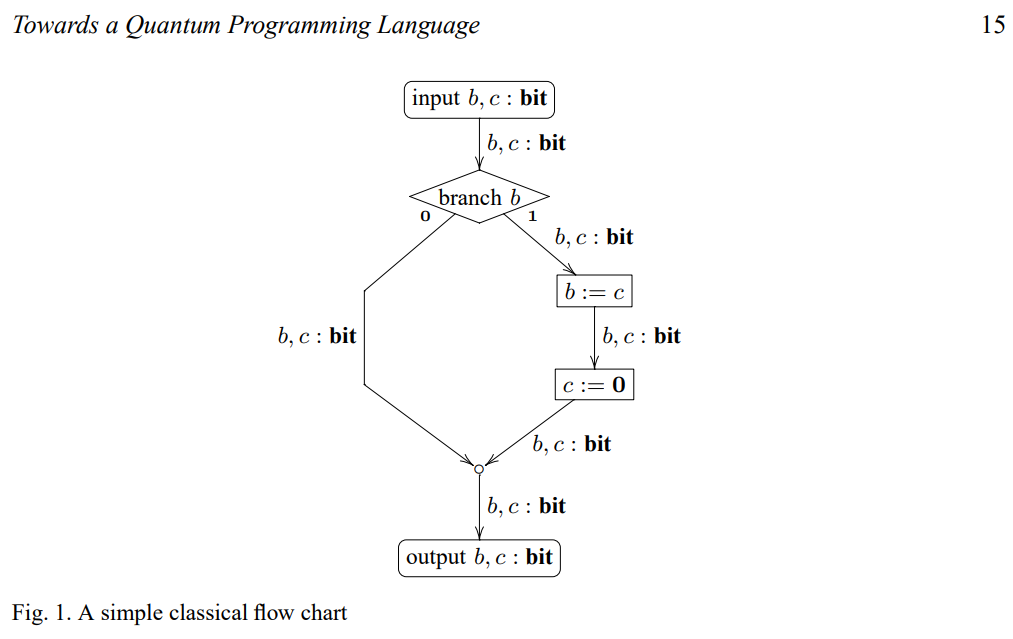

### Quantum Computing Simulators

Going further high-level, we come to quantum circuit simulators. Quantum computing simulators not only allow for the simple construction of circuits in a programming language, but may run an input vector through a circuit to simulate the probabalistic results moment by moment. For instance, take the Quantum Forier Transform (QFT) - a simulator can simply compute the Fourier transform classically, and update the qubit states (note that it *could* also properly simulate the full circuit for QFT). This allows for advanced simulations to include features such as noise, error rates, run-times for individual operations, and so on.

# Cirq

Finally, we come to the simulator of focus in this notebook. Cirq was announced as an open source Python framework for Noisy Intermediate Scale Quantum (NISQ) computers on Google's AI Blog, on July 18, 2018 \[5\], fully available at https://github.com/quantumlib/Cirq. Cirq is actively used on Google's "Bristlecone" quantum processor, and has even recently been incorporated into TensorFlow Quantum (also by Google), "an open-source library for the rapid prototyping of quantum ML models" \[6\]. TensorFlow Quantum is a very recent development just announced on March 9, 2020.

### Notable features

#### Graphical ASCII printing of circuits

In [2]:
# This example is modified from https://github.com/quantumlib/Cirq .

# Pick a qubit.
qubit = cirq.GridQubit(0, 0)

# Create a circuit
circuit = cirq.Circuit(
    cirq.X(qubit)**0.5,  # Square root of NOT.
    cirq.measure(qubit, key='m')  # Measurement.
)
print("Circuit:")
print(circuit)

# Simulate the circuit several times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=20)
print("Ran circuit 20 times. Results:")
print(result)

Circuit:
(0, 0): ───X^0.5───M('m')───
Ran circuit 20 times. Results:
m=00101001001100001011


#### Moment-based circuits

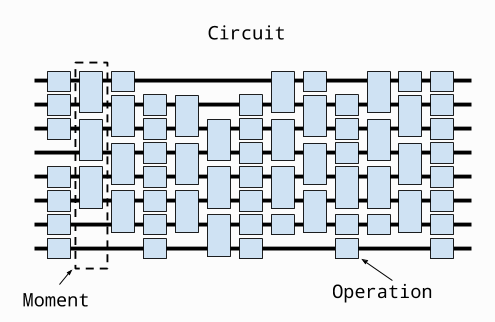

(credit [cirq.readthedocs.io]())

By grouping operations into "moments", Cirq constructs operators in parallel and better simulation of scheduled operations on real hardware. This also permits inspection of the state of a circuit at each moment:

In [3]:
qubits = cirq.LineQubit.range(3)
circuit = cirq.Circuit(
    cirq.IdentityGate(num_qubits = 3).on(*qubits),
    cirq.H(qubits[0]),
    cirq.H(qubits[2]),
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.CNOT(qubits[1], qubits[2])
)
print(circuit, "\n")

simulator = cirq.Simulator()
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    print('state at step %d: %s' % (i, step.dirac_notation(3)) + "\n")

0: ───I───H───@───────
      │       │
1: ───I───────X───@───
      │           │
2: ───I───H───────X─── 

state at step 0: |000⟩

state at step 1: 0.5|000⟩ + 0.5|001⟩ + 0.5|100⟩ + 0.5|101⟩

state at step 2: 0.5|000⟩ + 0.5|001⟩ + 0.5|110⟩ + 0.5|111⟩

state at step 3: 0.5|000⟩ + 0.5|001⟩ + 0.5|110⟩ + 0.5|111⟩



### Easily extensible operations and classes

Cirq is designed to be extensible with abstract classes for gates/operations, simulators, etc. This allows for creation of operations such as unitary operations corresponding to a complex function. The catch is that Cirq allows such operations not to be reflective of the full circuit - that is, the operation does not have to be the sum of normally-defined gates, but can simply hide a classical operation. In the next section, we will see how Cirq can use this to abstract the hardest part of Shor's algorithm.

# Shor's algorithm with Cirq

### Review

A brief review of the procedure for Shor's algorithm \[7\] is as follows:

___


We begin by picking a number $N$ to be factored.

##### Classical component

1. Pick a random number $a < N$.
2. Compute $\gcd(a, N)$. If $\gcd(a, N) \neq 1$, then this common divisor is a nontrivial factor of $N$, so the algorithm is done (though for large numbers it is likely that the algorithm can be run again on those factors). Otherwise, we proceed.
3. Use the **quantum component** to determine $r$, the period of the function $f(x) = a^x \mod N$.
4. If any of the following conditions are true, return to step 1.
    - $r = 0$
    - No candidate $r$ was found
    - $r$ is odd
    - $a^{\frac{r}{2}} \equiv -1 \mod N$
    - $\gcd(a^{\frac{r}{2}}+1\text{ mod }N, N) = 1$
5. We can factor $N$ by $\gcd(a^{\frac{r}{2}}+1\text{ mod }N, N)$.

##### Quantum component

We receive $a, N$ with which we must solve the period $r$ for $f(x) = a^x \mod N$. We define the unitary operation $$U_f |x, 0^q\rangle = |x, f(x)\rangle, \ \ f(x) = a^x \text{ mod } N.$$

1. Let $n_0$ be the number of bits in N. Let $n$ be the unique integer satisfying $N^2 \leq 2^n \leq 2N^2$. Initialize an input and output qubit register, with $n_0$ and $n$ qubits respectively, to the state $|\psi_0\rangle = |0\ldots 0\rangle_n|0\ldots 0\rangle_{n_0}$.
2. Let $q=2^n$. Prepare a superposition $$|\psi_1\rangle = \frac{1}{\sqrt{q}}\sum_{x=0}^{q-1}|x\rangle|0\rangle$$ by applying $q$ Hadamard gates.
3. Apply $U_f$ so that $|\psi_2\rangle = U_f|\psi_1\rangle.$
4. Measure the output register of $|\psi_2\rangle$ (recall this register has size $n_0$), and discard the result of that measurement (the point is to force the input register into a particular superposition). This puts the input register into state $$|\psi_3\rangle = \frac{1}{\sqrt{m}}\sum_{k=0}^{m-1}|x_0 + kr\rangle.$$
5. Apply the Quantum Fourier Transform (QFT) to $|\psi_3\rangle$ to obtain $|\psi_4\rangle = QFT|\psi_3\rangle$.
    - *Note: Many sources describe incorrectly describe this as the "inverse QFT". This confusion is due to the fact that QFT is the quantum analog of the inverse discrete Fourier transform - but it should properly be referred to as just "QFT". Still, Cirq follows the trend of calling this the "inverse QFT".*
6. Measure $y$ from the input register of $|\psi_4\rangle$.
7. Determine the continued fraction representation of $y/q$. Test each convergent $j'/r'$ in order, where $j'/r'$ is reduced to lowest terms. If at any point $r' < N$ and $$|\frac{y}{q}-\frac{j'}{r'}|\leq\frac{1}{2q}, $$ then $r'$ is the candidate value for the period. Return $r'$ to the classical component's step 3.

___

With this in mind, let's first examine how Cirq can deal with the circuit for modular exponentiation in Shor's algorithm, satisfying the unitary operation

$$U_f |x, 0^q\rangle = |x, f(x)\rangle, \ \ f(x) = a^x \text{ mod } N$$

This is not at all a simple circuit, and minimizing the number of operations to achieve this unitary function for variables $a, N$ has been the subject of much recent research and contention. Shor's landmark paper did not specify how this unitary operation could be achieved, not even discussing the number of qubits needed for the operation. Given that this operation is seen as **the bottle-neck** for applying Shor's algorithm, the debate over optimizing such a circuit is warranted.

In “Fast Quantum Modular Exponentiation Architecture for Shor’s Factorization Algorithm” \[8\] (2013), Pavlidis and Gizopoulos present a circuit with a depth near $2000n^2$ requiring $9n+2$ qubits, where $n$ represents the number of bits of the classical number being factored, where "the total quantum cost of the proposed design is $1600n^3$. The implementation is complicated, and this notebook will not attempt to program that circuit into Cirq. Instead, we'll use a simple trick to ignore the physical circuit requirements entirely, and simply *pretend* we have such a physical device ready for use. The following code creates an ArithmeticOperation in Cirq which sweeps all the troublesome circuitry under the rug.

In [4]:
# Code modified from https://github.com/quantumlib/Cirq/blob/master/examples/shor.py

from typing import Callable, List, Optional, Sequence, Union

class ModularExp(cirq.ArithmeticOperation):
    def __init__(self, target: Sequence[cirq.Qid],
                 exponent: Union[int, Sequence[cirq.Qid]], base: int,
                 modulus: int) -> None:
        if len(target) < modulus.bit_length():
            raise ValueError(f'Register with {len(target)} qubits is too small '
                             f'for modulus {modulus}')
        self.target = target
        self.exponent = exponent
        self.base = base
        self.modulus = modulus

    def registers(self) -> Sequence[Union[int, Sequence[cirq.Qid]]]:
        return self.target, self.exponent, self.base, self.modulus

    def with_registers(
            self,
            *new_registers: Union[int, Sequence['cirq.Qid']],
    ) -> cirq.ArithmeticOperation:
        if len(new_registers) != 4:
            raise ValueError(f'Expected 4 registers (target, exponent, base, '
                             f'modulus), but got {len(new_registers)}')
        target, exponent, base, modulus = new_registers
        return ModularExp(target, exponent, base, modulus)

    def apply(self, *register_values: int) -> int:
        assert len(register_values) == 4
        target, exponent, base, modulus = register_values
        if target >= modulus:
            return target
        return target ^ (base**exponent) % modulus

    def _circuit_diagram_info_(
            self,
            args: cirq.CircuitDiagramInfoArgs,
    ) -> cirq.CircuitDiagramInfo:
        assert args.known_qubits is not None
        wire_symbols: List[str] = []
        t, e = 0, 0
        for qubit in args.known_qubits:
            if qubit in self.target:
                if t == 0:
                    if isinstance(self.exponent, Sequence):
                        e_str = 'e'
                    else:
                        e_str = str(self.exponent)
                    wire_symbols.append(
                        f'ModularExp(t*{self.base}**{e_str} % {self.modulus})')
                else:
                    wire_symbols.append('t' + str(t))
                t += 1
            if isinstance(self.exponent, Sequence) and qubit in self.exponent:
                wire_symbols.append('e' + str(e))
                e += 1
        return cirq.CircuitDiagramInfo(wire_symbols=tuple(wire_symbols))

This may seem oddly simple for such a complicated circuit. The magic is in the method:

```
    def apply(self, *register_values: int) -> int:
        assert len(register_values) == 4
        target, exponent, base, modulus = register_values
        if target >= modulus:
            return target
        return (target * base**exponent) % modulus
```

Here, we see that this Cirq operation really just wraps `a**x % N`. Of course, this still means we get a classical run-time when factoring numbers, but that is to be expected.

### The Algorithm

In [5]:
'''
Attempt to factor N with a single run of Shor's algorithm.
If this returns None, then it probablistically failed and
must be run again.
If this returns -1, then the number is prime.
'''

def shor_factor(N, seed=None, verbose=False):
    if type(N) is not int:
        raise TypeError("n must be an integer.")
    if N > (2 ** 30):
        raise ValueError("Number is too large. Try n <= 2^30.")
    if N < 1:
        raise ValueError("Number must be positive integer greater than 1.")
        
    if N % 2 == 0:
        if verbose:
            print(f"{N} has trivial factor of 2.")
        return 2, N // 2
    
    # using sympy.isprime is certainly 'cheating' - but Shor's algorithm
    # doesn't work on prime numbers, so we can save some wasted effort here.
    if sympy.isprime(N):
        if verbose:
            print(f"{N} is prime. Aborting.")
        return -1
    
    '''
    1. Pick a random number  𝑎<𝑁
    '''
    random.seed(seed)
    a = random.randint(2, N-1)
    if verbose:
        print(f"Chose random number a={a}.")
    
    '''
    2. Compute  gcd(𝑎,𝑁) . If  gcd(𝑎,𝑁)≠1 , then this common divisor 
    is a nontrivial factor of  𝑁 , so the algorithm is done 
    (though for large numbers it is likely that the algorithm 
    can be run again on those factors). Otherwise, we proceed.
    '''
    gcd = math.gcd(N, a)
    if gcd != 1:
        if verbose:
            print(f"gcd({N}, {a}) is {gcd}, which is a trivial factor.")
        return gcd, N // gcd
    if verbose:
        print(f"a is relatively prime to N.")
    
    '''
    3. Use the quantum component to determine  𝑟 , 
    the period of the function  𝑓(𝑥)=𝑎^𝑥 mod𝑁 .
    '''
    if verbose:
        print(f"Finding order of `{a}**x % {N}`.")
    r = quantum_find_order(a, N, seed, verbose)
    if verbose:
        print(f"Quantum routine returned period r={r}.")
    
    '''
    4. If any of the following conditions are true, return to step 1.
    '''
    # No candidate 𝑟′ was found
    # 𝑟 is odd
    # 𝑎^(𝑟/2)≡−1mod𝑁
    # gcd(𝑎^(r/2),𝑁)=1
    if (r == 0 or
            r is None or
            r % 2 == 1):
        if verbose:
            print(f"The period r={r} failed on classical step 4. Try algorithm again.")
        return None
    
    c = (a**(r // 2)) % N
    d = math.gcd(c+1, N)
    if (c % N == N-1) or d == 1:
        if verbose:
            print(f"The period r={r} failed on classical step 4. Try algorithm again.")
        return None
        
    '''
    5. We can factor  𝑁  into  𝑔𝑐𝑑(𝑎^(𝑟/2)±1,𝑁) .
    '''
    if verbose:
        print("Algorithm succeeded. Returning factors.")
    return d, N // d

'''
The quantum component of Shor's algorithm. Returns 'r',
the candidate period.
'''
def quantum_find_order(a, N, seed=None, verbose=False):
    n_0 = N.bit_length()
    n = 2 * n_0 + 3
    
    '''
    1. Initialize an input and output qubit register, 
    with  𝑛  and  𝑛0  qubits respectively, to 
    the state  |𝜓0⟩=|0…0⟩𝑛|0…0⟩𝑛0 .
    '''
    input_qubits = cirq.LineQubit.range(n)
    output_qubits = cirq.LineQubit.range(n, n + n_0)
    order_circuit = cirq.Circuit()

    '''
    2. Let  𝑞=2^𝑛 . Prepare a superposition
    |𝜓1⟩=1𝑞⎯⎯√∑𝑥=0𝑞−1|𝑥⟩|0⟩

    by applying  𝑞  Hadamard gates.
    '''
    q = 2 ** n
    order_circuit.append(cirq.H.on_each(*input_qubits))

    '''
    3. Apply  𝑈𝑓  so that  |𝜓2⟩=𝑈𝑓|𝜓1⟩.
    '''
    order_circuit.append(
        ModularExp(output_qubits, input_qubits, a, N)
    )

    '''
    4. Measure the output register of  |𝜓2⟩  
    (recall this register has size  𝑛 ), 
    and discard the result of that measurement 
    (the point is to force the input register into 
    a particular superposition). This puts the input 
    register into state |𝜓3⟩.
    '''
    order_circuit.append(cirq.measure(*output_qubits, key='output'))

    '''
    5. Apply the Quantum Fourier Transform (QFT) 
    to  |𝜓3⟩  to obtain  |𝜓4⟩=𝑄𝐹𝑇|𝜓3⟩ .
    '''
    order_circuit.append(cirq.QFT(*input_qubits, inverse=True))

    '''
    6. Measure  𝑦  from the input register of  |𝜓4⟩
    '''
    order_circuit.append(cirq.measure(*input_qubits, key='input'))
    if verbose:
        print("Generating order-finding circuit:\n")
        print(order_circuit, "\n")
    simulator = cirq.Simulator(seed=seed)
    input_result = simulator.run(order_circuit).measurements['input'][0]
    y = int("".join(str(x) for x in input_result), 2)
    if verbose:
        print(f"Circuit returned value of input register, y={y}")

    '''
    7. Determine the continued fraction representation of  𝑦/𝑞 .
    Test each convergent  𝑗′/𝑟′  in order, where  𝑗′/𝑟′  is reduced 
    to lowest terms. If at any point  𝑟′<𝑁  and |𝑦/𝑞−𝑗′/𝑟′|≤1/2𝑞, 
    then  𝑟′  is the candidate value for the period. 
    Return  𝑟′  to the classical component's step 3.
    '''
    def continued_fraction(num, denom):
        res = []
        quo, rem = divmod(num, denom)
        while rem != 0:
            res = res + [quo]
            quo, rem = divmod(denom, rem)
            denom = (denom-rem)//quo
        return res + [quo]
    
    def cf_to_frac(cf):
        num, denom = 1, 0
        for u in reversed(cf):
            num, denom = denom + (num * u), num
        return num, denom

    cf = continued_fraction(y, q)
    if verbose:
        print(f"Continued fraction for {y}/{q} is {cf}.")
    
    # test each convergent
    for i in range(len(cf)):
        j, r = cf_to_frac(cf[0:i+1])
        if math.fabs((y/q)-(j/r)) <= (1/(2*q)):
            if verbose:
                print(f"Using convergent j/r = {j}/{r}. Returning to classical routine.")
            if r == 1:
                return 0
            return r
    # all convergents failed
    if verbose:
        print("All convergents failed. Returning to classical routine.")
    return None

Now, we are ready to run the algorithm. Note that this is a *very expensive* algorithm on classical systems - so we use a rather low $N$ to test the algorithm, or else we wait an eternity to factor a number like 99.

In [6]:
for i in range(5):
    res = shor_factor(21, seed=i+13, verbose=True)
    if res:
        print(res)
        break
    print("-"*30 + "\n")

Chose random number a=10.
a is relatively prime to N.
Finding order of `10**x % 21`.
Generating order-finding circuit:

0: ────H───e0─────────────────────────QFT^-1────────M('input')───
           │                          │             │
1: ────H───e1─────────────────────────#2────────────M────────────
           │                          │             │
2: ────H───e2─────────────────────────#3────────────M────────────
           │                          │             │
3: ────H───e3─────────────────────────#4────────────M────────────
           │                          │             │
4: ────H───e4─────────────────────────#5────────────M────────────
           │                          │             │
5: ────H───e5─────────────────────────#6────────────M────────────
           │                          │             │
6: ────H───e6─────────────────────────#7────────────M────────────
           │                          │             │
7: ────H───e7─────────────────────────#8

# Sources:

\[1\]: E. Knill. Conventions for quantum pseudocode. Technical Report LAUR-96-2724, LANL, 1996. (https://pdfs.semanticscholar.org/60d1/e63ca31555ec7013c5eb9a8a63788398fd14.pdf)

\[2\]: Selinger, Peter. (2004). A Brief Survey of Quantum Programming Languages. 1-6. (https://www.mscs.dal.ca/~selinger/papers/flops04.pdf)

\[3\]: B. Ömer, A Procedural Formalism for Quantum Computing, Master thesis (computing science), Technical University of Vienna, 1998. (http://tph.tuwien.ac.at/~oemer/doc/qcldoc.pdf)

\[4\]: Selinger, Peter. “Towards a Quantum Programming Language.” Mathematical Structures in Computer Science, vol. 14, no. 4, Aug. 2004, pp. 527–86. Cambridge Core, doi:10.1017/S0960129504004256. (https://www.mscs.dal.ca/~selinger/papers/qpl.pdf)

\[5\]: "Announcing Cirq: An Open Source Framework for NISQ Algorithms." (https://ai.googleblog.com/2018/07/announcing-cirq-open-source-framework.html)

\[6\]: "Announcing TensorFlow Quantum: An Open Source Library for Quantum Machine Learning." (https://ai.googleblog.com/2020/03/announcing-tensorflow-quantum-open.html)

\[7\]: Shor, Peter W. “Polynomial-Time Algorithms for Prime Factorization and Discrete Logarithms on a Quantum Computer.” SIAM Journal on Computing, vol. 26, no. 5, Oct. 1997, pp. 1484–509. arXiv.org, doi:10.1137/S0097539795293172. (https://arxiv.org/pdf/quant-ph/9508027.pdf)

\[7\]: Pavlidis, Archimedes, and Dimitris Gizopoulos. “Fast Quantum Modular Exponentiation Architecture for Shor’s Factorization Algorithm.” ArXiv:1207.0511 [Quant-Ph], Nov. 2013. arXiv.org, http://arxiv.org/abs/1207.0511. (https://arxiv.org/pdf/1207.0511.pdf)

\[8\]: Cirq on GitHub. (https://github.com/quantumlib/Cirq/blob/master/)